# CHATBOT

Cel

Utwórzyc prototyp chatbota za pomocą **seq2seq Encoder-Decoder Bidrectional LSTM z uwagą**   i **Transformer model**, który może generować naturalnie brzmiące odpowiedzi symulujące rozmowę między ludźmi. Aby to osiągnąć, użyjemy **natural language processing** do wstępnego przetwarzania danych z [Cornell Movie Dialogues Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). Ta baza danych zawiera rozmowy między postaciami z różnych filmów i seriali telewizyjnych i dlatego jest dobrym punktem wyjścia dla takiego modelu.

Zadanie generowania znaczącego tekstu jest warunkowo podzielone na dwa podzadania. Najpierw sieć neuronowa musi przeprowadzić analizę tekstu referencyjnego, a następnie, po zrozumieniu wzorców konstruowania fraz, utworzyć nowy tekst, kopiując sposób konstruowania fraz tekstu, na którym sieć neuronowa została przeszkolona.

Przykładowe kroki tworzenia sieci neuronowej generującej tekst są następujące:

*   Przygotowanie tekstów do szkolenia-dobór materiałów do szkolenia sieci neuronowej, tj. znalezienie odpowiednich pod względem objętości dialogów, tekstów itp.
*   Przetwarzanie wstępne (usuwanie "śmieci", tokenizacja) tekstu do nauki. Wykluczenie "zbędnych" informacji z tekstów.
*   Konwersje do formatu nadającego się do zasilania sieci neuronowej (wektoryzacja, sekwencje numeryczne).
*   Tworzenie nowego tekstu przy użyciu jakiegoś algorytmu. Na przykład odpowiednia architektura sieci neuronowej.
*   Konwertacja tekstu w kodzie czytelnym maszynowo na język naturalny.










Tworząc takie algorytmy, napotykamy szereg problemów:

*   Niejednoznaczność języka. Na przykład słowa [homonimy](https://pl.wikipedia.org/wiki/Homonimia_(j%C4%99zykoznawstwo)) — słowa brzmią tak samo, ale mają różne znaczenia, w zależności od kontekstu. Bez kontekstu nie jest jasne, jakie słowo miało na myśli.
*   Asymetria języka — znaczenie jest kodowane w różny sposób w różnych językach. Sposób przetwarzania nadaje się do analizy jednego języka nie będzie działać na innym. Na przykład różnice w czasach i przestrzeniach.
*   Baza edukacyjna jest dobrze opracowana dla języka angielskiego. W przypadku innych języków z bazami sytuacja nie wygląda tak dobrze.
*   Duże wektory tekstu, a tym samym wysokie wymagania dotyczące zasobów obliczeniowych (pamięć, GPU/TPU) i długotrwałe uczenie się.





Pierwszy model chatbota będzie wykorzystywał technologię Sequence-2-sequence. Do jej realizacji zostaną wykorzystane technologie:
- Embedding do wektoryzacji.
- Rekurencyjne sieci neuronowe (RNN), w szczególności LSTM, Bideractional LSTM.
- Mechanizm uwagi (Attention)

# Sequence-to-Sequence (Seq2Seq)

Model Seq2Seq składa się z dwóch głównych jednostek: encoder i decoder.

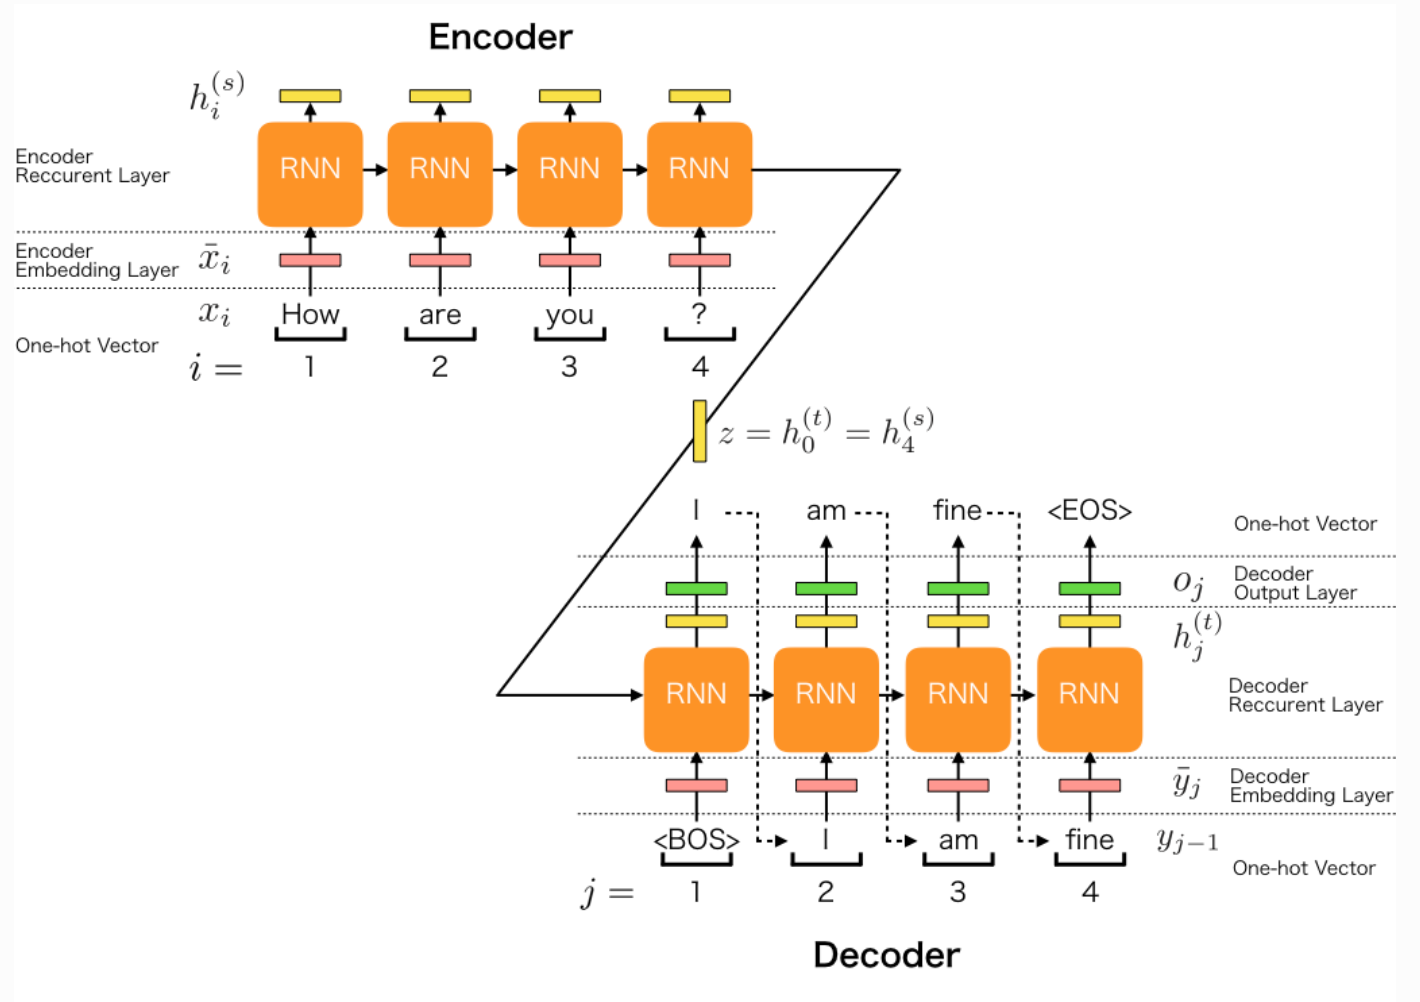

[sourse](https://docs.chainer.org/en/stable/examples/seq2seq.html)

- Do komórek sieci rekurencyjnej encoder podawana jest oryginalna fraza podzielona na słowa: "How are you?».
- Encoder przetwarza je i na wyjściu otrzymuje zakodowaną sekwencję z.
- Decoder, oprócz informacji z wyjścia encoder-a, otrzymuje odpowiedź referencyjną, na której się uczy: "I am fine".
- W procesie uczenia się dekoder zmienia swoje wagi w taki sposób, że po otrzymaniu oryginalnego pytania na wejście, najlepiej, aby wydać frazę referencyjną na wyjście.
- Podczas treningu fraza jest otoczona tagiem. W tym przypadku BOS - jest znacznikiem początkowym i EOS - jest znacznikiem końcowym.

# Szkolenie seq2seq modele

Powinna istnieć baza pytań i baza odpowiedzi. Konieczne jest, aby były dokładnie pytania i odpowiedzi na nie. W przypadku sieci neuronowej powinno być jasne, że na tekst pytania udzielona jest pewna odpowiedź.

W przypadku modelu treningowego sekwencja szkolenia będzie następująca:
- Na wejściu encodera składamy pytanie. Na przykład: "How are you?».
- Encoder zakoduje go za pomocą warstwy embedding do konwersji słów na wektor wielowymiarowy i LSTM.
- Na wyjściu LSTM encoder-a zwraca ukryte stany h i c.
- Dekoder zawiera również warstwę embedding do wektoryzacji odpowiedzi i LSTM.
- W przypadku dekodera odpowiedź referencyjna z próbki treningowej jest oprawiona w znaczniki otwarcia i zamknięcia: 'start' i 'end'. Tagi mogą być dowolne.
- Stany h i c z encodera i odpowiedź referencyjna jest podawana do wejścia decodera. Uczy się na nim i tworzy odpowiedź. Na przykład "I am fine'end'".
- Dekoder w procesie uczenia się "zrozumie", że na tagu początkowym frazy 'start' na wejściu i stanu z encoderem trzeba zacząć generować odpowiedź.
- Ponadto dekoder "zdaje sobie sprawę", że wygenerowaną sekwencję musi zakończyć znacznikiem 'end'.

Obsługa pytania przez model roboczy będzie następująca:
- Encoder w modelu roboczym jest taki sam jak w modelu treningowym. Jedyną różnicą jest to, że pytanie wpisane przez użytkownika zostanie przesłane do jego wejścia, a nie kilka pytań i odpowiedzi z bazy szkoleniowej.
- Model roboczy używa wcześniej wytrenowanego dekodera, ale tylko znacznik 'start' zostanie mu przesłany do wejścia.
- Dekoder "rozumie", że po przybyciu znacznika 'start' należy wziąć stan z encodera i wygenerować jakieś (jedno) słowo odpowiedzi.
- Idealnie, jesli wygeneruje pierwsze słowo w sekwencji: "I".
- Otrzymane słowo "I" jest podawane do wejścia dekodera wraz ze stanem uzyskanym w poprzednim kroku na wyjściu dekodera.
- Następnie otrzymane słowo "I" jest ponownie podawane do wejścia dekodera wraz ze stanem uzyskanym w poprzednim kroku. Na wyjściu dekoder tworzy słowo 'am'.
- Nowe słowo wraz ze stanem w pętli jest ponownie podawane do wejścia dekodera, dopóki dekoder nie uzna, że fraza jest kompletna i zwróci tag 'end'.

## Model treningowy

---



### Praca encodera seq2seq


Rozważę krok po kroku pracę encodera.

- *Na wejściu fraza oczyszczona od znaków interpunkcyjnych:* `[How are you]`
- *Zdanie jest konwertowane na sekwencję liczb za pomocą NLTK Tokenizera. Wyjście ma 3 liczby według liczby słów na wejściu*: `[95 18 10]`
- *Długość pytania może być różna, a wymiar wejścia neuronu jest stały. Wszystkie pytania trzeba prowadzić do jednej długości. Odbywa się to poprzez dodanie 0. Na przykład długość pytania może wynosić nie więcej niż 5 słów. Uzupełniamy nasze 3 cyfry 2 zerami*: `[95 18 10 0 0]`
- **Na wejściu encodera pierwsza jest warstwa embedding.**
- *Warstwa embedding przekształca każde słowo w przestrzeń wektorową o podanym przez nas wymiarze. Na przykład pierwsze jest słowo cześć zakodowane liczbą 95. Warstwa embedding przekształca to słowo na przykład w przestrzeń dwestimeryczną.*
- **Wynikowa macierz zostanie podana do LSTM/Bideractional LSTM.**



### **Encoder (warstwy + wyniki)**		
Embedding		
LSTM/Bideractional LSTM		
Na wyjściu LSTM - encoder state(ES):  h, c

### Praca decodera seq2seq
Rozważę krok po kroku pracę decodera.



- *Bierzemy odpowiedź na zadane pytanie z próbki szkoleniowej*:  `[all is fine]`
- *W pierwszym kroku dodajemy do tej sekwencji znaczniki początku `<start >` i końca `<end >`*  `[<start > all is fine <end>]`
- *Zdanie jest konwertowane na sekwencję liczb za pomocą Tokenizera. Wyjście ma 5 liczb według liczby słów na wejściu.* `[1 45 18 24 2]`
- *Długość pytania może się różnić. Pytania doprowadzamy do jednej długości przez dodanie 0 do sekwencji słów. Na przykład maksymalna długość odpowiedzi może wynosić 7 - dodajemy na końcu dwa 0.* `[1 45 18 24 2 0 0]`

### **Decoder (warstwy + wyniki i dodatkowe wejścia)**
Embedding

Z encoder ES na wejście  ->  LSTM

Wartości ze wszystkich komórek LSTM:     h,  c

Dense z liczba neuronów = długość słownika i
funkcja aktywacji - softmax

## Model roboczy

---


W modelu roboczym encoder jest taki sam jak w modelu treningowym, więc nie rozważam go osobno.

### Praca decoder seq2seq


- *Dodajemy tag startowy do wcześniej przeszkolonego decodera* `<start>`
- *Używamy Tokenizera do konwersji sekwencji na liczbę. Otrzymujemy jedną liczbę-1*. `[1]`
- *LSTM pobiera dane z warstwy embedding i encoder (ES)*
- *Pierwsza wartość zwracana przez Decoder jest podawana do warstwy dense*
- *Wartość wydana na wyjściu dense jest obsługiwana przez argmax. Wybierany jest indeks, dla którego prawdopodobieństwo jest maksymalne.*
- *Zgodnie z uzyskanym indeksem ze słownika wybierane jest odpowiednie słowo.*
- **Dwa inne wyjścia LSTM nazwijmy DS (decoder state)**
- *W drugim kroku pętli słowo uzyskane w poprzednim kroku jest podawane do wejścia architektury* `all`
- *Używamy Tokenizera Keras do konwersji sekwencji na liczbę. Otrzymujemy jedną liczbę.* `45`
- *Podajemy otrzymane słowo do wejścia decodera.*
- *Podajemy do LSTM zamiast ES poprzedni stan decodera (DS).*
- *Na wyjściu po warstwie dense i argmax otrzymujemy słowo "is"*
- *Na wyjściu po warstwie dense i argmax otrzymujemy tag zamykający "` <end>`", na którym zatrzymujemy cykl generowania frazy odpowiedzi.*
- *Pętla zostanie również zatrzymana po osiągnięciu określonej maksymalnej liczby iteracji-maksymalnej długości frazy odpowiedzi.*

**Import Zależności**

In [ ]:
import os
import re
import nltk
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Bidirectional, Input, Embedding, LSTM, GRU
from keras import Model
import time
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn import model_selection
import random

# Inicjalizacja TPU/GPU

Aby poprawić naukę w Colab, wybierzemy  akcelerator TPU / GPU.

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


Do tego chatbota użyjemy Cornell Movie Dialogues Corpus-dużej, bogatej w metadane kolekcji dialogów między 10 292 parami bohaterów filmowych wyodrębnionych z surowych scenariuszy filmowych.

Pomysł wykorzystania tych danych polega na tym, że rozmowy filmowe imitują codzienną rozmowę między ludźmi.

Ponieważ celem jest stworzenie chatbota, który może prowadzić naturalną rozmowę z osobą, wykorzystujemy te dane, aby sprawdzić, czy możemy wyszkolić chatbota, który w rozmowie brzmi jak osoba.

### Pobieranie Danych

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

lines_filename = os.path.join(path_to_dataset, 'movie_lines.txt')
conversations_filename = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

9928704/9916637 [==============================] - 0s 0us/step


## **Poniżej znajduje się podsumowanie danych.**

## movie_lines.txt-zawiera 304713 linijek z filmów.

zawiera rzeczywisty tekst każdej wypowiedzi

pola:
*lineID, 
characterID (kto wypowiedział to zdanie), 
movieID, 
imię postaci, tekst wypowiedzi.* 

## movie_conversations.txt - zawiera 83098 rozmów. 

pola:

*characterID pierwszej postaci biorącej udział w rozmowie, 
characterID drugiej postaci biorącej udział w rozmowie, 
movieID filmu, w którym doszło do rozmowy,
lista wypowiedzi, które tworzą rozmowę, w porządku chronologicznym: **`['line 1','line ID 2', 'lineIDN']`** musi być dopasowana do movie_lines.txt do rekonstrukcji rzeczywistej treści*


In [ ]:
#read lines into list
lines = open(lines_filename, errors='ignore').read().split('\n')
#read conversations into list
conversations = open(conversations_filename,encoding=('utf-8'), errors='ignore').read().split('\n')

print(lines[:3])
print(conversations[:3])

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!', 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!', 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.']
["u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']", "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']", "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']"]


## Wstępne przetwarzanie danych

Dane są prezentowane w formie rozmowy należącej do różnych gatunków filmowych. Wyodrębniłam wszystkie ciągi dialogowe za pomocą plików movie_conversations i movie_lines. Wykorzystałam każdą rozmowę jako pytanie, po którym następuje odpowiedź.

In [ ]:
def preprocess():
    #read lines into list
    lines = open(lines_filename, errors='ignore').read().split('\n')
    #read conversations into list
    conversations = open(conversations_filename,encoding=('utf-8'), errors='ignore').read().split('\n')

    movie_lines = {}
    for line in lines:
        line = line.split(' +++$+++ ')
        movie_lines[line[0]] = line[-1]
        
    conversations = [conv.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(',',"").split() for conv in conversations]
    
    questions = []
    answers = []
    
    for conv in conversations:
        for i in range(len(conv)-1):
            questions.append(movie_lines[conv[i]])
            answers.append(movie_lines[conv[i+1]])
            
    return questions, answers

In [ ]:
questions, answers = preprocess()
print(questions[:3])
print(answers[:3])

['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.', "Well, I thought we'd start with pronunciation, if that's okay with you.", 'Not the hacking and gagging and spitting part.  Please.']
["Well, I thought we'd start with pronunciation, if that's okay with you.", 'Not the hacking and gagging and spitting part.  Please.', "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?"]


## Konwertujemy dane na małe litery, przycinamy i usuwamy wszystkie znaki nieliterowe

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", r"i am", text)
    text = re.sub(r"\'s", r" is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"thats", r"that is", text)
    text = re.sub(r"\'em", r"them", text)
    text = re.sub(r"gonna", r"going to", text)
    text = re.sub(r"btw", r"by the way", text)
    text = re.sub(r'[^\w\s]', r'', text)
    text = re.sub(r"[!.?,*/|'\_^\+:;<>=#$-`~]", r"", text) 
    text.strip()
    return text

In [ ]:
clean_questions = [clean_text(q) for q in questions]
clean_answers = [clean_text(a) for a in answers]
del(questions, answers)
pairs = list(zip(clean_questions, clean_answers))

In [ ]:
print(pairs[:6])

[('can we make this quick  roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad  again', 'well i thought we would start with pronunciation if that is okay with you'), ('well i thought we would start with pronunciation if that is okay with you', 'not the hacking and gagging and spitting part  please'), ('not the hacking and gagging and spitting part  please', 'okay then how about we try out some french cuisine  saturday  night'), ('you are asking me out  that is so cute what is your name again', 'forget it'), ('no no it is my fault  we did not have a proper introduction ', 'cameron'), ('cameron', 'the thing is cameron  i am at the mercy of a particularly hideous breed of loser  my sister  i ca not date until she does')]


In [ ]:
max_q_length = 14
max_a_length = 12

del(clean_questions, clean_answers)

questions = [pair[0] for pair in pairs
             if len(pair[0].split())<=max_q_length 
             and len(pair[1].split())<=max_a_length 
             and len(pair[0].split())>=1 
             and len(pair[1].split())>=1]
answers = [pair[1] for pair in pairs 
           if len(pair[0].split())<=max_q_length 
           and len(pair[1].split()) <=max_a_length 
           and len(pair[0].split())>=1 
           and len(pair[1].split())>=1]

In [ ]:
print(questions[:3])
print(answers[:3])

['well i thought we would start with pronunciation if that is okay with you', 'not the hacking and gagging and spitting part  please', 'you are asking me out  that is so cute what is your name again']
['not the hacking and gagging and spitting part  please', 'okay then how about we try out some french cuisine  saturday  night', 'forget it']


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def vocabulary(text, threshold):
    # tokens
    word_count = [['PAD', 0], ['BOS', 1], ['EOS', 2], ['UNK', 3]]
    
    tokenized_text = nltk.tokenize.word_tokenize(text)
    counter = nltk.Counter(tokenized_text)

    counter = [item for item in counter.items() if item[1]>=threshold] #word length

    del(tokenized_text)

    for w, c in counter:
        word_count.append([w, c])
    
    print(word_count[:10])

    vocab_dict = {}
    
    for word,_ in word_count:
        vocab_dict[word] = len(vocab_dict)
       
    count = 0
    data= []
    for word in text.split():
        index = vocab_dict.get(word, 0)
        if index == 0:
            count+=1
        data.append(index)
    del(word)
    word_count[0][1] = count
    
    reverse_vocab_dict = dict(zip(vocab_dict.values(), vocab_dict.keys()))
    return data, word_count, vocab_dict, reverse_vocab_dict

In [ ]:
vocab_data, vocab_word_count, vocab_dict, vocab_dict_rev = vocabulary(' '.join(questions + answers), 14)

[['PAD', 0], ['BOS', 1], ['EOS', 2], ['UNK', 3], ['well', 5022], ['i', 61665], ['thought', 1461], ['we', 11644], ['would', 6102], ['start', 390]]


In [ ]:
vocab_data[:10]

[4, 5, 6, 7, 8, 9, 10, 0, 11, 12]

In [ ]:
vocab_word_count[:10]

[['PAD', 85025],
 ['BOS', 1],
 ['EOS', 2],
 ['UNK', 3],
 ['well', 5022],
 ['i', 61665],
 ['thought', 1461],
 ['we', 11644],
 ['would', 6102],
 ['start', 390]]

In [ ]:
len(vocab_dict)

4488

In [ ]:
vocab_dict['fine']

672

In [ ]:
vocab_dict_rev[743]

'happy'

In [ ]:
answers = ["BOS "+answer for answer in answers]
answers = [answer+" EOS" for answer in answers]

In [ ]:
answers[:3]

['BOS not the hacking and gagging and spitting part  please EOS',
 'BOS okay then how about we try out some french cuisine  saturday  night EOS',
 'BOS forget it EOS']

In [ ]:
def encoder_decoder_inputs(questions, answers, vocab_dict):
    encoder_input = []
    decoder_input = []

    for line in questions:
        lst = []
        for word in line.split():
            if word not in vocab_dict.keys():
                lst.append(vocab_dict['UNK'])
            else:
                lst.append(vocab_dict[word])
    
        encoder_input.append(lst)
        del(lst)
    del(line)
    for line in answers:
        lst = []
        for word in line.split():
            if word not in vocab_dict.keys():
                lst.append(vocab_dict['UNK'])
            else:
                lst.append(vocab_dict[word])
        decoder_input.append(lst)
        del(lst)
    del(line)
    return encoder_input, decoder_input

In [ ]:
with tf.device('/GPU:0'):

  encoder_input, decoder_input = encoder_decoder_inputs(
      questions[:35000], 
      answers[:35000],  
      vocab_dict)

In [ ]:
encoder_input[:3]

[[4, 5, 6, 7, 8, 9, 10, 3, 11, 12, 13, 14, 10, 15],
 [16, 17, 3, 18, 3, 18, 3, 19, 20],
 [15, 21, 22, 23, 24, 12, 13, 25, 26, 27, 13, 28, 29, 30]]

In [ ]:
decoder_input[:3]

[[1, 16, 17, 3, 18, 3, 18, 3, 19, 20, 2],
 [1, 14, 66, 52, 218, 7, 510, 24, 400, 219, 3, 106, 114, 2],
 [1, 112, 32, 2]]

In [ ]:
max_length = 20
dict_size = len(vocab_dict)

In [ ]:
def pad_sentences(encoder_inputs, decoder_inputs):
    #using pad_sequences, all sentences are aligned in length by adding 0
    encoder_inputs = sequence.pad_sequences(encoder_inputs, max_length, padding="post", truncating = 'post')
    decoder_inputs = sequence.pad_sequences(decoder_inputs, max_length, padding="post", truncating = 'post')
    
    decoder_final_outputs = []
    for di in decoder_inputs:
        decoder_final_outputs.append(di[1:])

    decoder_final_outputs = sequence.pad_sequences(decoder_final_outputs, max_length, padding='post', truncating = 'post')
    decoder_final_outputs = to_categorical(decoder_final_outputs, dict_size)
    return encoder_inputs, decoder_inputs, decoder_final_outputs

In [ ]:
test_size = int(len(encoder_input)*0.2) #7000
val_size  = int((len(encoder_input)-test_size)*0.2) #5600

encoder_input_test, decoder_input_test = encoder_input[:test_size], decoder_input[:test_size]
encoder_input_val, decoder_input_val = encoder_input[test_size: test_size + val_size], decoder_input[test_size: test_size + val_size]
encoder_input_train, decoder_input_train = encoder_input[ test_size +val_size:], decoder_input[ test_size+val_size:]

with tf.device('/GPU:0'):

  encoder_input_train, decoder_input_train, decoder_output_train = pad_sentences(encoder_input_train, 
                                                                                 decoder_input_train)
  encoder_input_val, decoder_input_val, decoder_output_val = pad_sentences(encoder_input_val, 
                                                                           decoder_input_val)
  encoder_input_test, decoder_input_test, decoder_output_test = pad_sentences(encoder_input_test, 
                                                                              decoder_input_test)

In [ ]:
encoder_input_train.shape, decoder_input_train.shape, decoder_output_train.shape

((22400, 20), (22400, 20), (22400, 20, 4488))

In [ ]:
encoder_input_val.shape, decoder_input_val.shape, decoder_output_val.shape

((5600, 20), (5600, 20), (5600, 20, 4488))

In [ ]:
encoder_input_test.shape, decoder_input_test.shape, decoder_output_test.shape

((7000, 20), (7000, 20), (7000, 20, 4488))

Uwaga(Attention) jest to mechanizm, który pozwala sieci neuronowej skierować bliższe spojrzenie na niektóre z elementów wejściowych przetwarzanej sekwencji. Jeśli bardziej formalnie, każdemu elementowi w sekwencji przypisuje się jakiś klucz K i wartość V. Następnie zapytaniem wektorowym Q można zapytać o żądane informacje. Istnieje wiele sposobów, jak to zrobić konkretnie. W pracy wykorzystano Bahdanau attention.

In [ ]:
class BahdanauAttention(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W1, W2, and V
    """
    def compute_output_shape(self, input_shape):
        return [tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])), tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))]
   
    
    def __init__(self, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W1 = self.add_weight(name = 'W1', shape= tf.TensorShape((input_shape[0][2], input_shape[0][2])), initializer='uniform', trainable=True)
        self.W2 = self.add_weight(name = 'W2', shape = tf.TensorShape((input_shape[1][2], input_shape[0][2])), initializer = 'uniform', trainable=True)
        self.V = self.add_weight(name = 'V', shape = tf.TensorShape((input_shape[0][2], 1)), initializer = 'zeros', trainable=True)

        super(BahdanauAttention, self).build(input_shape)

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_output_seq, decoder_output_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_output_seq.shape)
            print('decoder_out_seq>', decoder_output_seq.shape)

        def energy_step(inputs, states):
            encoder_seq_len, encoder_hidden = encoder_output_seq.shape[1], encoder_output_seq.shape[2]
            decoder_hidden = inputs.shape[-1]

            W1_dot_s = keras.backend.dot(encoder_output_seq, self.W1)

            W2_dot_h = keras.backend.expand_dims(keras.backend.dot(inputs, self.W2), 1) 
            Ws_plus_Uh = keras.backend.tanh(W1_dot_s + W2_dot_h)
            e_i = keras.backend.squeeze(keras.backend.dot(Ws_plus_Uh, self.V), axis=-1)
            e_i = keras.backend.softmax(e_i)

            return e_i, [e_i]


        def context_step(inputs, states):
            c_i = keras.backend.sum(encoder_output_seq * keras.backend.expand_dims(inputs, -1), axis=1)
            return c_i, [c_i]
    
        fake_state_c = keras.backend.sum(encoder_output_seq, axis=1)
        fake_state_e = keras.backend.sum(encoder_output_seq, axis=2)

        last_out, e_outputs, _  = keras.backend.rnn(energy_step, decoder_output_seq, [fake_state_e],)
        last_out, c_outputs, _ = keras.backend.rnn(context_step, e_outputs, [fake_state_c],)
    
        return c_outputs, e_outputs

In [ ]:
class Chatbot:
    
    def __init__(self, dict_size, latent_dim, embedding_size, max_length):
        self.encoder_input = keras.layers.Input(shape=(max_length, ), name = 'encoder_input')
        self.decoder_input = keras.layers.Input(shape=(max_length, ), name = "decoder_input")
        
        self.encoder_embedding =keras.layers.Embedding(dict_size, embedding_size)(self.encoder_input)

        #The recurrent network used in the model (LSTM or GRU) uses the 
        #return_state = True property to get a compressed representation of the submitted word (thought vector) 
        #in the form of two state vectors h and c at the output.
        self.encoder_lstm = keras.layers.LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.6)
       
        self.bidirectional = keras.layers.Bidirectional(self.encoder_lstm, name = 'bidirectional')
        
        self.encoder_outputs, fw_state_h, fw_state_c, bw_state_h, bw_state_c = self.bidirectional(self.encoder_embedding)
        
        state_h = keras.layers.concatenate([fw_state_h, bw_state_h], axis = -1)
        state_c = keras.layers.concatenate([fw_state_c, bw_state_c], axis = -1)
        self.encoder_state = [state_h, state_c]
        
        
        
        self.decoder_embedding = keras.layers.Embedding(dict_size, embedding_size)(self.decoder_input)
        self.decoder = keras.layers.LSTM(latent_dim*2, return_sequences = True, return_state = True, dropout = 0.6)
       
        self.decoder_outputs, _, _ = self.decoder(self.decoder_embedding, self.encoder_state)
        self.attention = BahdanauAttention()
        attention_output, attention_state = self.attention([self.encoder_outputs, self.decoder_outputs])
        decoder_concat_input = keras.layers.Concatenate(axis=-1)([self.decoder_outputs, attention_output])

        
        self.dense_output3 = Dense(dict_size, activation = 'softmax')
        self.decoder_output = self.dense_output3(decoder_concat_input)
        self.model = Model([self.encoder_input, self.decoder_input], self.decoder_output)
        self.optimizer = keras.optimizers.Adam(learning_rate=0.05)
        self.loss = keras.losses.CategoricalCrossentropy()
        self.model.compile(self.optimizer, self.loss, metrics=["accuracy"])
        
        
    def train(self, encoder_input, decoder_input, decoder_output, encoder_input_val=None, decoder_input_val=None, decoder_output_val=None, batch_size = 128, epoch = 100):
        checkpoint_filepath = 'model'+ time.strftime("%d%m%y%H%M")+'.h5'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)
        
        model_scheduler_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=tf.math.exp(-0.1), patience=3, min_lr=0.00001, cooldown=20, verbose=1)
        model_scheduler_acc = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=tf.math.exp(-0.1), patience=3, min_lr=0.00001, cooldown=20, verbose=1)
        model_scheduler_loss_val = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=tf.math.exp(-0.1), patience=3, min_lr=0.00001, cooldown=20, verbose=1)
        model_scheduler_acc_val = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=tf.math.exp(-0.1), patience=3, min_lr=0.00001, cooldown=20, verbose=1)
        self.history = self.model.fit([encoder_input, decoder_input], 
                                      decoder_output, 
                                      batch_size = batch_size, 
                                      epochs = epoch, 
                                      callbacks = [ model_scheduler_loss, 
                                                   model_scheduler_acc, 
                                                   model_scheduler_loss_val, 
                                                   model_scheduler_acc_val,
                                                   model_checkpoint_callback], 
                                      validation_data = ([encoder_input_val, decoder_input_val], 
                                                         decoder_output_val)) 
        #callbacks = [ model_scheduler_loss, model_scheduler_acc, model_scheduler_loss_val, model_scheduler_acc_val, model_checkpoint_callback])
        self.save_model()

    def save_model(self):
        path = "model"+time.strftime("%d%m%y%H%M") + ".h5"
        path_weight = "model_weights"+time.strftime("%d%m%y%H%M") + ".h5"
        self.model.save(path)
        self.model.save_weights(path_weight)
        
    #self.history = self.model.history()

    def enc_model(self):
        self.encoder_model = Model(self.encoder_input, [self.encoder_outputs, self.encoder_state])
        #return encoder_model
    
    def dec_model(self):
        decoder_input_h = Input(shape=(128*2,))
        decoder_input_c = Input(shape=(128*2,))
        decoder_state_inputs = [decoder_input_h, decoder_input_c]
        
        decoder_outputs, state_h, state_c = self.decoder(self.decoder_embedding, initial_state=decoder_state_inputs)
        decoder_states2 = [state_h, state_c]
        self.decoder_model = Model([self.decoder_input, decoder_state_inputs], [decoder_outputs] + decoder_states2)
        #return decoder_model
    
    def inferece(self, latent_size, sentence, to_dict_rev, max_a_length):
        
        enc_output, state = self.encoder_model.predict(np.array(sentence))
        target = np.zeros((1, 1))
        target[0,0] = vocab_dict['BOS']
        ind = False
        translation = ''
        while not ind:
            decoder_outputs, state_h, state_c = self.decoder_model.predict([target] + state)
            attention_output, attention_state = self.attention([enc_output, decoder_outputs])
            decoder_concat_input = tf.keras.layers.Concatenate(axis = -1)([decoder_outputs, attention_output])
            decoder_concat_input = self.dense_output3(decoder_concat_input)    
            from_categorical = np.argmax(decoder_concat_input[0, -1, :])
            
            word_from_categorical = to_dict_rev[from_categorical]+' '
            
            if word_from_categorical != 'EOS ':
                translation += word_from_categorical
                
            if word_from_categorical == 'EOS ' or len(translation.split())>max_a_length:
                ind = True
                
            target = np.zeros((1, 1))
            target[0,0] = from_categorical
            state = [state_h, state_c]
        
        return translation


In [ ]:
with tf.device('/GPU:0'):

  model = Chatbot(dict_size, 128, 50, max_length)

In [ ]:
'''
del(questions)
del(answers)
del(encoder_input)
del(decoder_input)
'''

'\ndel(questions)\ndel(answers)\ndel(encoder_input)\ndel(decoder_input)\n'

In [ ]:
print(model.model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 50)       224400      ['encoder_input[0][0]']          
                                                                                                  
 decoder_input (InputLayer)     [(None, 20)]         0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 20, 256),    183296      ['embedding[0][0]']              
                                 (None, 128),                                                 

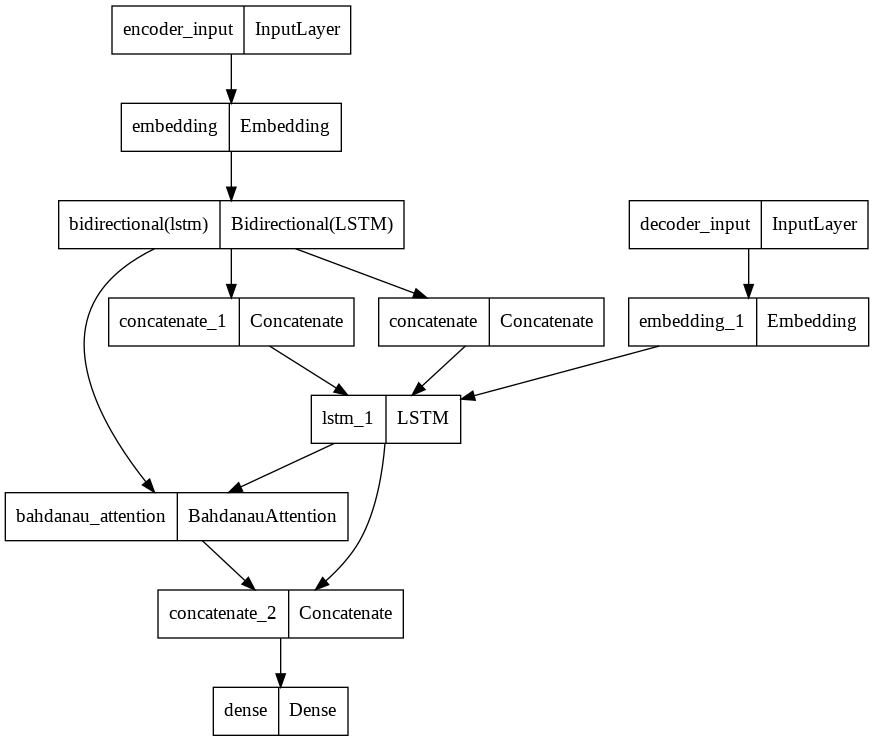

In [ ]:
plot_model(model.model)

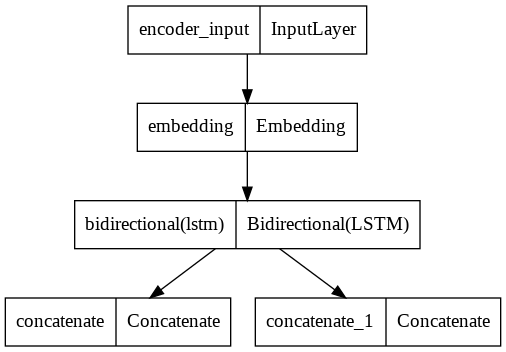

In [ ]:
encoder_model = model.enc_model()
plot_model(model.encoder_model)

In [ ]:
model.encoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 50)       224400      ['encoder_input[0][0]']          
                                                                                                  
 bidirectional (Bidirectional)  [(None, 20, 256),    183296      ['embedding[0][0]']              
                                 (None, 128),                                                     
                                 (None, 128),                                                     
                                 (None, 128),                                               

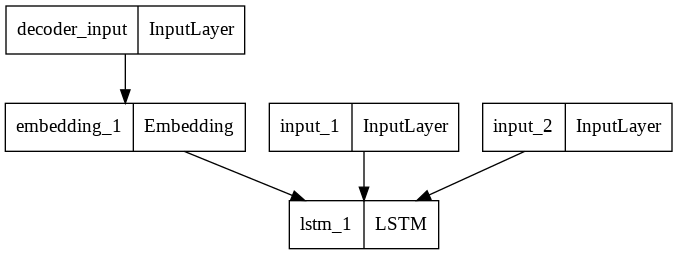

In [ ]:
decoder_model = model.dec_model()
plot_model(model.decoder_model)

In [ ]:
model.decoder_model.summary() 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 20)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 50)       224400      ['decoder_input[0][0]']          
                                                                                                  
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

In [ ]:
with tf.device('/GPU:0'):

  model.train(encoder_input = encoder_input_train, 
              decoder_input = decoder_input_train, 
              decoder_output = decoder_output_train, 
              encoder_input_val = encoder_input_val, 
              decoder_input_val = decoder_input_val, 
              decoder_output_val = decoder_output_val, 
              batch_size = 1024, 
              epoch = 100)

Epoch 1/100
22/22 [==============================] - 152s 7s/step - loss: 3.8372 - accuracy: 0.5747 - val_loss: 2.0001 - val_accuracy: 0.7068 - lr: 0.0500
Epoch 2/100
22/22 [==============================] - 144s 7s/step - loss: 1.7903 - accuracy: 0.7237 - val_loss: 1.7529 - val_accuracy: 0.7339 - lr: 0.0500
Epoch 3/100
22/22 [==============================] - 140s 6s/step - loss: 1.6741 - accuracy: 0.7347 - val_loss: 1.6685 - val_accuracy: 0.7423 - lr: 0.0500
Epoch 4/100
22/22 [==============================] - 139s 6s/step - loss: 1.6022 - accuracy: 0.7402 - val_loss: 1.6198 - val_accuracy: 0.7463 - lr: 0.0500
Epoch 5/100
22/22 [==============================] - 138s 6s/step - loss: 1.5508 - accuracy: 0.7438 - val_loss: 1.5805 - val_accuracy: 0.7493 - lr: 0.0500
Epoch 6/100
22/22 [==============================] - 139s 6s/step - loss: 1.5140 - accuracy: 0.7468 - val_loss: 1.5624 - val_accuracy: 0.7508 - lr: 0.0500
Epoch 7/100
22/22 [==============================] - 137s 6s/step - lo

In [ ]:
model.model.save("BiLSTM_attention_model.h5")

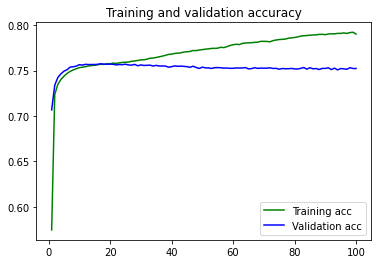

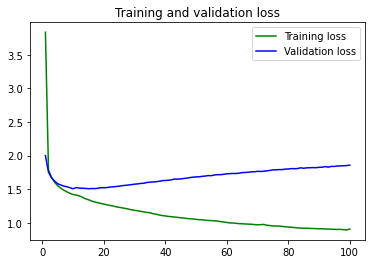

In [ ]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
'''
del(encoder_input_val, decoder_input_val, decoder_output_val)
del(encoder_input_train, decoder_input_train, decoder_output_train)
'''

'\ndel(encoder_input_val, decoder_input_val, decoder_output_val)\ndel(encoder_input_train, decoder_input_train, decoder_output_train)\n'

In [ ]:
model.model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)

219/219 [==============================] - 22s 102ms/step - loss: 1.8596 - accuracy: 0.7547


[1.8596347570419312, 0.7546928524971008]

In [ ]:
for i in range(10):
    seq_index = np.random.randint(1, len(encoder_input_train))
    # Take one sequence (part of the training set)
    # for trying out decoding.
    
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    translation = model.inferece(128, input_seq, vocab_dict_rev, 12)
    print(input_seq.shape)
    print('-')
    print('Input-',questions[seq_index:seq_index+1])
    print(translation)

(1, 20)
-
Input- ['what']
i am not going to take you to be UNK 
(1, 20)
-
Input- ['so what is unique']
they are not going to faint 
(1, 20)
-
Input- ['come take a look an entiresuite of mainframe computer']
myers 
(1, 20)
-
Input- ['go home now']
goodnight 
(1, 20)
-
Input- ['choices']
you are not even sick freak 
(1, 20)
-
Input- ['jeff call the fbi right away']
hello 
(1, 20)
-
Input- ['so just how big was this fare']
i am not going to credit card 
(1, 20)
-
Input- ['could be']
where are you stuck 
(1, 20)
-
Input- ['i am sorry that i became so upset']
i am sorry 
(1, 20)
-
Input- ['it is just my heart']
i am sorry 


In [ ]:
def prepro_sentence(sentence, max_sent, vocab):
    sentence = clean_text(sentence)
    sentence_input = []
    for word in sentence.split():
        if word not in vocab.keys():
            sentence_input.append(vocab['UNK'])
        else:
            sentence_input.append(vocab[word])
    
    return sequence.pad_sequences([sentence_input], max_sent, padding="post", truncating="post")

In [ ]:
sentence = ''
while 1:
    sentence = input('user:')
    if(sentence=='quit'):
        break
        
    sentence = prepro_sentence(sentence, 20, vocab_dict)
    translation = model.inferece(128, sentence, vocab_dict_rev, 12)
    print('chatbot: '+translation)

user:How are you?
chatbot: i am fine 
user:Great! What are you doing?
chatbot: i am not cheating i am dreaming 
user:Do you want coffee?
chatbot: i am sure i am sure 
user:What about?
chatbot: i am not 
user:Do you like coffee?
chatbot: i am not sure 
user:Do you like a rain?
chatbot: no 
user:I dont like it too
chatbot: you are not even be mad at all 
user:quit
